In [1]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import warnings
warnings.filterwarnings('ignore')


# import detok models
from models.detok import detok_BB

print("libraries imported successfully!")
print(f"torch version: {torch.__version__}")
print(f"cuda available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"cuda device: {torch.cuda.get_device_name(0)}")


libraries imported successfully!
torch version: 2.6.0+cu124
cuda available: True
cuda device: NVIDIA A100-SXM4-80GB


In [2]:
def center_crop_arr(pil_image, image_size):
    """center crop image to target size"""
    while min(*pil_image.size) >= 2 * image_size:
        pil_image = pil_image.resize(
            tuple(x // 2 for x in pil_image.size), resample=Image.BOX
        )
    scale = image_size / min(*pil_image.size)
    pil_image = pil_image.resize(
        tuple(round(x * scale) for x in pil_image.size), resample=Image.BICUBIC
    )
    arr = np.array(pil_image)
    crop_y = (arr.shape[0] - image_size) // 2
    crop_x = (arr.shape[1] - image_size) // 2
    return Image.fromarray(arr[crop_y:crop_y+image_size, crop_x:crop_x+image_size])

def prepare_image_transform(img_size=256):
    """prepare image transformation pipeline"""
    return transforms.Compose([
        transforms.Lambda(lambda pil_image: center_crop_arr(pil_image, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),  # normalize to [-1, 1]
    ])

def denormalize_image(tensor):
    """convert normalized tensor back to [0, 1] range for visualization"""
    return tensor * 0.5 + 0.5

def tensor_to_pil(tensor, denormalize=True):
    """convert tensor to pil image for visualization"""
    if tensor.dim() == 4:
        tensor = tensor.squeeze(0)  # remove batch dimension
    if denormalize:
        tensor = denormalize_image(tensor)
    tensor = torch.clamp(tensor, 0, 1)
    return transforms.ToPILImage()(tensor)

In [3]:

device = "cuda" if torch.cuda.is_available() else "cpu"
# create detok-bb model (base encoder, base decoder)
model_path = "released_model/detok-BB-gamm3.0-m0.7.pth"
tokenizer = detok_BB(img_size=256, patch_size=16, token_channels=16, mask_ratio=0.7, gamma=3.0)
checkpoint = torch.load(model_path, map_location="cpu", weights_only=False)
tokenizer.load_state_dict(checkpoint["model_ema"], strict=True)
del checkpoint
tokenizer.to(device)
tokenizer.eval()
tokenizer.requires_grad_(False)

# load finetuned tokenizer
model_path = "released_model/detok-BB-gamm3.0-m0.7-decoder_tuned.pth"
tokenizer_ft = detok_BB(img_size=256, patch_size=16, token_channels=16, mask_ratio=0.7, gamma=3.0)
checkpoint = torch.load(model_path, map_location="cpu", weights_only=False)
tokenizer_ft.load_state_dict(checkpoint["model_ema"], strict=True)
del checkpoint
tokenizer_ft.to(device)
tokenizer_ft.eval()
tokenizer_ft.requires_grad_(False)

# vitok: baseline tokenizer without any denoising
vitok = detok_BB(img_size=256, patch_size=16, token_channels=16, mask_ratio=0.0, gamma=0.0)
model_path = "released_model/vitok-BB.pth"
checkpoint = torch.load(model_path, map_location="cpu", weights_only=False)
vitok.load_state_dict(checkpoint["model_ema"], strict=True)
del checkpoint
vitok.to(device)
vitok.eval()
vitok.requires_grad_(False)

# print model info
total_params = sum(p.numel() for p in tokenizer.parameters())
print(f"detok model parameters: {total_params / 1e6:.1f}M")
total_params = sum(p.numel() for p in vitok.parameters())
print(f"vitok model parameters: {total_params / 1e6:.1f}M")

# prepare image transform
transform = prepare_image_transform(img_size=256)

detok model parameters: 171.7M
vitok model parameters: 171.7M


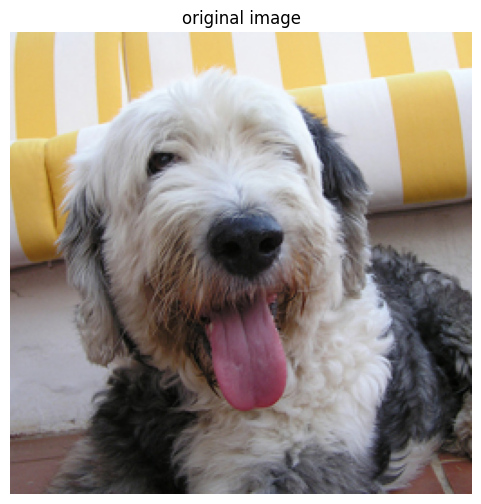

In [4]:
sample_image = Image.open("data/imagenet/gt-image50000/038519.png").convert("RGB")
# display the original image
plt.figure(figsize=(6, 6))
plt.imshow(sample_image)
plt.title("original image")
plt.axis('off')
plt.show()

image tensor shape: torch.Size([1, 3, 256, 256]), image tensor min: -1.000, image tensor max: 1.000


tokens shape: torch.Size([1, 16, 16, 16]) (B, C, H, W)
tokens range: [-16.868, 16.088]
reconstructed shape: torch.Size([1, 3, 256, 256]) (B, C, H, W)
reconstructed range: [0.000, 1.000]
finetuned tokens shape: torch.Size([1, 16, 16, 16]) (B, C, H, W)
finetuned tokens range: [-16.865, 16.091]
finetuned reconstructed shape: torch.Size([1, 3, 256, 256]) (B, C, H, W)
finetuned reconstructed range: [0.000, 1.000]
vitok tokens shape: torch.Size([1, 16, 16, 16]) (B, C, H, W)
vitok tokens range: [-4.631, 3.668]
vitok reconstructed shape: torch.Size([1, 3, 256, 256]) (B, C, H, W)
vitok reconstructed range: [0.000, 1.000]


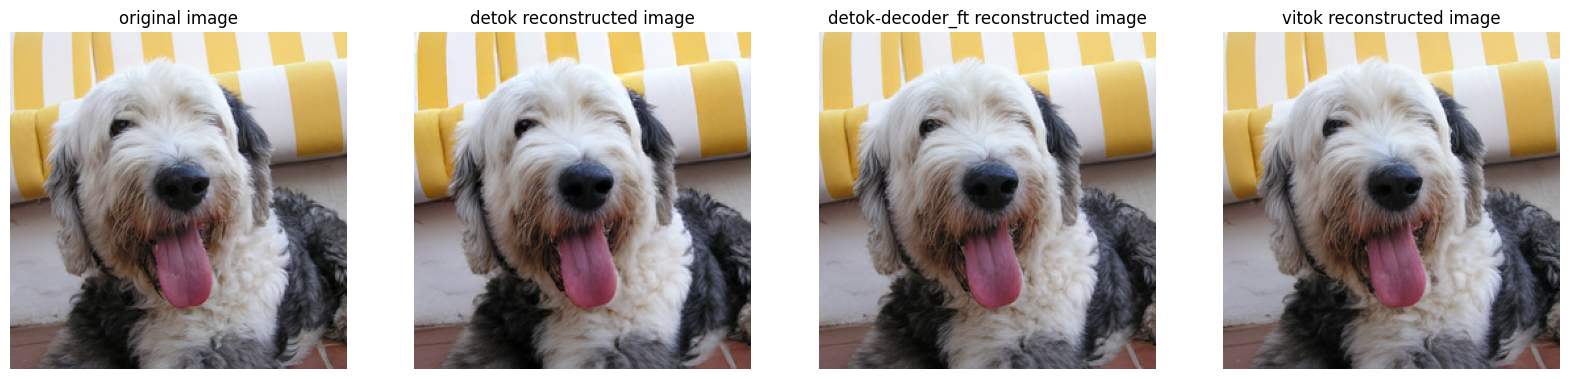

In [5]:
# prepare image transform
transform = prepare_image_transform(img_size=256)

# transform image to tensor
image_tensor = transform(sample_image).unsqueeze(0).to(device)  # add batch dimension
print(f"image tensor shape: {image_tensor.shape}, image tensor min: {image_tensor.min():.3f}, image tensor max: {image_tensor.max():.3f}")
with torch.no_grad():
    # tokenize: image -> latent tokens
    tokens = tokenizer.tokenize(image_tensor, sampling=False)
    print(f"tokens shape: {tokens.shape} (B, C, H, W)")
    print(f"tokens range: [{tokens.min():.3f}, {tokens.max():.3f}]")
    # reconstruct: latent tokens -> image
    reconstructed = tokenizer.detokenize(tokens)
    print(f"reconstructed shape: {reconstructed.shape} (B, C, H, W)")
    print(f"reconstructed range: [{reconstructed.min():.3f}, {reconstructed.max():.3f}]")

    # finetuned tokenizer
    tokens_ft = tokenizer_ft.tokenize(image_tensor, sampling=False)
    print(f"finetuned tokens shape: {tokens_ft.shape} (B, C, H, W)")
    print(f"finetuned tokens range: [{tokens_ft.min():.3f}, {tokens_ft.max():.3f}]")
    reconstructed_ft = tokenizer_ft.detokenize(tokens_ft)
    print(f"finetuned reconstructed shape: {reconstructed_ft.shape} (B, C, H, W)")
    print(f"finetuned reconstructed range: [{reconstructed_ft.min():.3f}, {reconstructed_ft.max():.3f}]")

    # vitok
    tokens_vitok = vitok.tokenize(image_tensor, sampling=False)
    print(f"vitok tokens shape: {tokens_vitok.shape} (B, C, H, W)")
    print(f"vitok tokens range: [{tokens_vitok.min():.3f}, {tokens_vitok.max():.3f}]")
    reconstructed_vitok = vitok.detokenize(tokens_vitok)
    print(f"vitok reconstructed shape: {reconstructed_vitok.shape} (B, C, H, W)")
    print(f"vitok reconstructed range: [{reconstructed_vitok.min():.3f}, {reconstructed_vitok.max():.3f}]")


original_pil = tensor_to_pil(image_tensor, denormalize=True)
reconstructed_pil = tensor_to_pil(reconstructed, denormalize=False)
reconstructed_ft_pil = tensor_to_pil(reconstructed_ft, denormalize=False)
reconstructed_vitok_pil = tensor_to_pil(reconstructed_vitok, denormalize=False)

# create side-by-side comparison
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# row 1: original and reconstructed images
axes[0].imshow(original_pil)
axes[0].set_title("original image")
axes[0].axis('off')
axes[1].imshow(reconstructed_pil)
axes[1].set_title("detok reconstructed image")
axes[1].axis('off')
axes[2].imshow(reconstructed_ft_pil)
axes[2].set_title("detok-decoder_ft reconstructed image")
axes[2].axis('off')
axes[3].imshow(reconstructed_vitok_pil)
axes[3].set_title("vitok reconstructed image")
axes[3].axis('off')
plt.show()


detok latents shape: torch.Size([1, 256, 16])
detok-decoder_ft latents shape: torch.Size([1, 256, 16])
vitok latents shape: torch.Size([1, 256, 16])


Detok-ft performs better than Detok. 
Its decoder is fine-tuned on clean latent tokens and loses denoising ability. 
Yet, it still outperforms Detok at test time. 
This shows the gain comes from better latent representations (determined by the encoder), not the decoder.


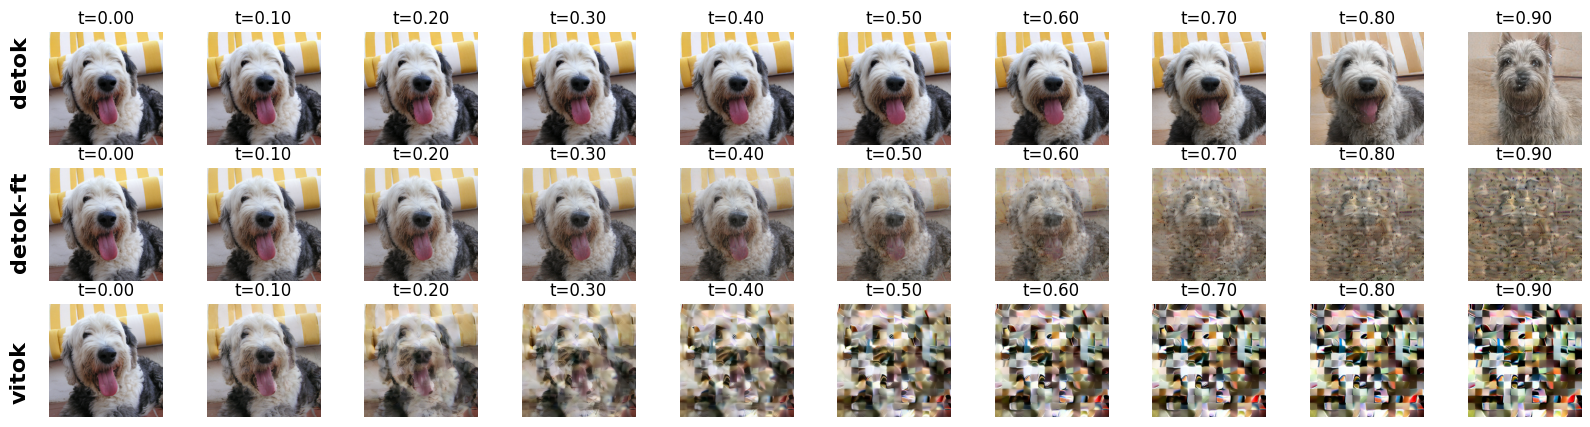

In [6]:
# denoising latent interpolative noise
detok_latents = tokenizer.encode(image_tensor, sampling=False, mask_ratio=0.0)[0]
detok_latents_ft = tokenizer_ft.encode(image_tensor, sampling=False, mask_ratio=0.0)[0]
vitok_latents = vitok.encode(image_tensor, sampling=False, mask_ratio=0.0)[0]
bsz, n_tokens, chans = detok_latents.shape
print(f"detok latents shape: {detok_latents.shape}")
print(f"detok-decoder_ft latents shape: {detok_latents_ft.shape}")
print(f"vitok latents shape: {vitok_latents.shape}")

# for reproducibility, comment out this line if you want to see different results
torch.manual_seed(18)
noise = torch.randn(bsz, n_tokens, chans, device=device) * tokenizer.gamma

detok_reconstructed_images = []
detok_reconstructed_images_ft = []
vitok_reconstructed_images = []
noise_levels = np.linspace(0.0, 1.0, 10, endpoint=False)
for noise_level in noise_levels:
    noise_level_tensor = torch.full((bsz, n_tokens, chans), noise_level, device=device)
    detok_deconstructed_latents = (1 - noise_level_tensor) * detok_latents + noise_level_tensor * noise
    detok_deconstructed_latents_ft = (1 - noise_level_tensor) * detok_latents_ft + noise_level_tensor * noise
    vitok_deconstructed_latents = (1 - noise_level_tensor) * vitok_latents + noise_level_tensor * noise
    detok_reconstructed = tokenizer.decoder(detok_deconstructed_latents)
    detok_reconstructed_images.append(tensor_to_pil(detok_reconstructed, denormalize=True))
    detok_reconstructed_ft = tokenizer_ft.decoder(detok_deconstructed_latents_ft)
    detok_reconstructed_images_ft.append(tensor_to_pil(detok_reconstructed_ft, denormalize=True))
    vitok_reconstructed = vitok.decoder(vitok_deconstructed_latents)
    vitok_reconstructed_images.append(tensor_to_pil(vitok_reconstructed, denormalize=True))

fig, axes = plt.subplots(3, len(noise_levels), figsize=(20, 5))
for i in range(len(noise_levels)):
    axes[0, i].imshow(detok_reconstructed_images[i])
    axes[0, i].set_title(f"t={noise_levels[i]:.2f}")
    axes[0, i].axis('off')
    axes[1, i].imshow(detok_reconstructed_images_ft[i])
    axes[1, i].set_title(f"t={noise_levels[i]:.2f}")
    axes[1, i].axis('off')
    axes[2, i].imshow(vitok_reconstructed_images[i])
    axes[2, i].set_title(f"t={noise_levels[i]:.2f}")
    axes[2, i].axis('off')

fig.text(0.11, 0.8, 'detok', fontsize=16, fontweight='bold', rotation=90, va='center')
fig.text(0.11, 0.5, 'detok-ft', fontsize=16, fontweight='bold', rotation=90, va='center')
fig.text(0.11, 0.2, 'vitok', fontsize=16, fontweight='bold', rotation=90, va='center')

print(
    "Detok-ft performs better than Detok. \n"
    "Its decoder is fine-tuned on clean latent tokens and loses denoising ability. \n"
    "Yet, it still outperforms Detok at test time. \n"
    "This shows the gain comes from better latent representations (determined by the encoder), not the decoder."
)


Detok-ft performs better than Detok. 
Its decoder is fine-tuned on clean latent tokens and loses inpainting ability. 
Yet, it still outperforms Detok at test time. 
This shows the gain comes from better latent representations (determined by the encoder), not the decoder.


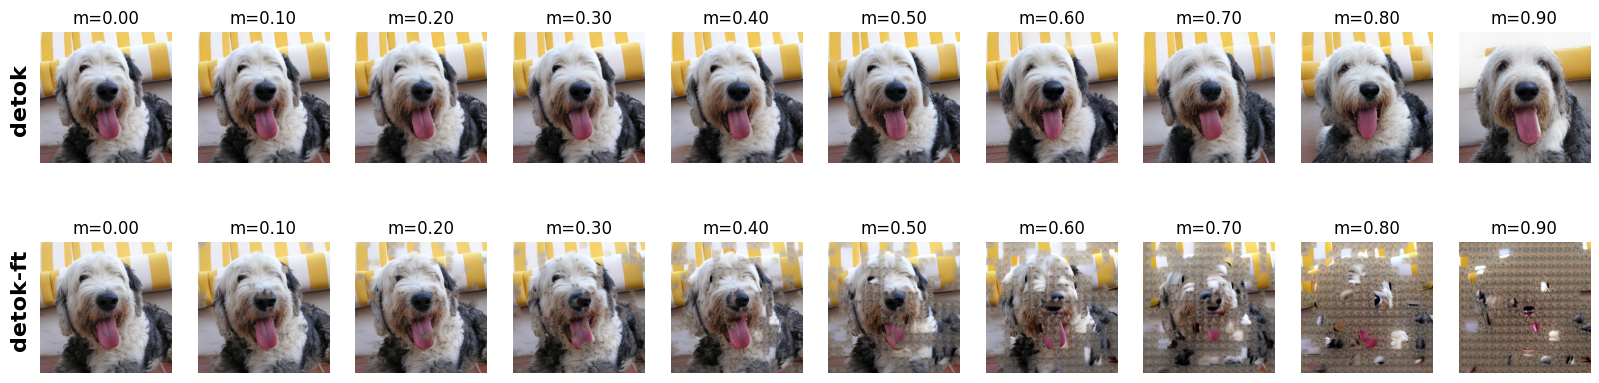

In [7]:
# denoising masking noise
detok_reconstructed_images = []
detok_reconstructed_images_ft = []
mask_ratios = np.linspace(0.0, 1.0, 10, endpoint=False)
# for reproducibility, comment out this line if you want to see different results
torch.manual_seed(18)
for mask_ratio in mask_ratios:
    detok_latents, _, ids_restore = tokenizer.encode(image_tensor, sampling=False, mask_ratio=mask_ratio)
    detok_reconstructed = tokenizer.decoder(detok_latents, ids_restore=ids_restore)
    detok_reconstructed_images.append(tensor_to_pil(detok_reconstructed, denormalize=True))
    detok_latents_ft, _, ids_restore_ft = tokenizer_ft.encode(image_tensor, sampling=False, mask_ratio=mask_ratio)
    detok_reconstructed_ft = tokenizer_ft.decoder(detok_latents_ft, ids_restore=ids_restore_ft)
    detok_reconstructed_images_ft.append(tensor_to_pil(detok_reconstructed_ft, denormalize=True))

fig, axes = plt.subplots(2, len(mask_ratios), figsize=(20, 5))
for i in range(len(mask_ratios)):
    axes[0, i].imshow(detok_reconstructed_images[i])
    axes[0, i].set_title(f"m={mask_ratios[i]:.2f}")
    axes[0, i].axis('off')
    axes[1, i].imshow(detok_reconstructed_images_ft[i])
    axes[1, i].set_title(f"m={mask_ratios[i]:.2f}")
    axes[1, i].axis('off')

fig.text(0.11, 0.7, 'detok', fontsize=16, fontweight='bold', rotation=90, va='center')
fig.text(0.11, 0.3, 'detok-ft', fontsize=16, fontweight='bold', rotation=90, va='center')
print(
    "Detok-ft performs better than Detok. \n"
    "Its decoder is fine-tuned on clean latent tokens and loses inpainting ability. \n"
    "Yet, it still outperforms Detok at test time. \n"
    "This shows the gain comes from better latent representations (determined by the encoder), not the decoder."
)